In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import math
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.util import img_as_ubyte

In [30]:
class Processing:
    
    def __init__(self, image_path, mask=None, df=None):
        self.image = cv2.imread(image_path)
        if self.image is None:
            raise ValueError("Image could not be read. Check the path.")
        if mask is not None:
            self.mask = mask
        else:
            self.mask = np.zeros(self.image.shape[:2], np.uint8)
        self.df = df

    def histogramming(self):
        histSize = 256
        histRange = (0, 256)
        accumulate = False
        b = self.image[:,:,0]
        b_hist = cv2.calcHist([b], [0], None, [histSize], histRange, accumulate=accumulate)
        plt.plot(b_hist)
        plt.show()
        b_hist_cum = b_hist.cumsum()
        plt.plot(b_hist_cum)
        plt.show()

    def homo_average(self, point, T):
        av_val = self.image[self.mask > 0].sum() / np.count_nonzero(self.image[self.mask > 0])                                             
        return abs(av_val - self.image[point]) <= T

    def region_growing(self, seed_point, homo_fun, r, T):
        mask = np.zeros(self.image.shape[:2], np.uint8)
        mask[seed_point] = 1
        count = 1
        while count > 0:
            count = 0
            local_mask = np.zeros(self.image.shape[:2], np.uint8)
            for i in range(r, self.image.shape[0] - r):
                for j in range(r, self.image.shape[1] - r):
                    if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                        if homo_fun((i, j), T):
                            local_mask[i, j] = 1
            count = np.count_nonzero(local_mask)
            mask += local_mask
        return mask * 255

    def calculate_entropy(self, glcm):
        glcm_normalized = glcm / np.sum(glcm)
        glcm_nonzero = glcm_normalized[glcm_normalized > 0]
        return -np.sum(glcm_nonzero * np.log2(glcm_nonzero))

    def glcm_analysis(self, distances=[1], angles=[0]):
        gray_image = rgb2gray(self.image)
        gray_image = img_as_ubyte(gray_image)
        
        glcm = graycomatrix(gray_image, distances=distances, angles=angles, levels=256, symmetric=True, normed=False)
        
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        entropy = self.calculate_entropy(glcm[:, :, 0, 0])
        
        features = {
            'contrast': contrast,
            'energy': energy,
            'homogeneity': homogeneity,
            'entropy': entropy
        }
        
        return glcm[:, :, 0, 0], features
    
    def visualize_glcm(self, glcm):
        plt.figure(figsize=(8, 6))
        plt.imshow(glcm, cmap='gray', interpolation='nearest')
        plt.title("Матрица взаимной встречаемости пикселя")
        plt.xlabel("Gray Level 1")
        plt.ylabel("Gray Level 2")
        plt.colorbar(label="Frequency")
        plt.show()

    def textural(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        mean = np.mean(gray_image)
        variance = np.var(gray_image)
        std_dev = np.std(gray_image)
        return mean, variance, std_dev
    
    def lavs_characteristics(self):
        gray_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
        mean = np.mean(laplacian)
        variance = np.var(laplacian)
        std_dev = np.std(laplacian)
        return mean, variance, std_dev

    def watershed_segmentation(self):
        image_gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
        ret, sure_fg = cv2.threshold(dist, 0.7 * dist.max(), 255, cv2.THRESH_BINARY) 
        sure_fg = sure_fg.astype(np.uint8)
        ret, markers = cv2.connectedComponents(sure_fg) 
        markers = cv2.watershed(self.image, markers)
        plt.imshow(markers, cmap="gray")
        #return segmented_image
        #return markers

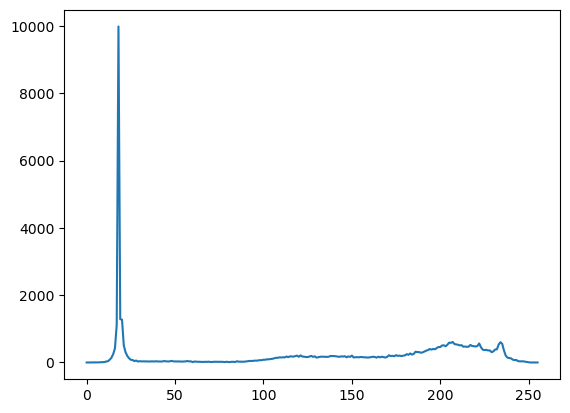

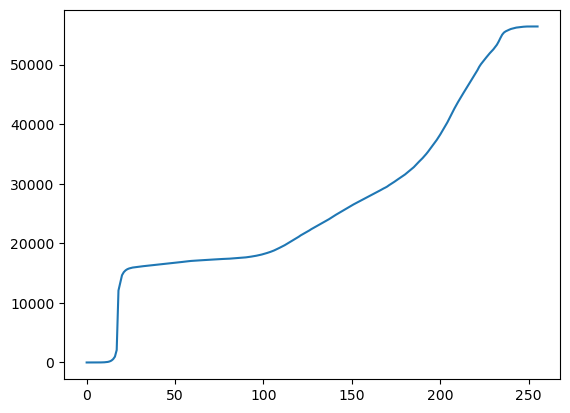

Характеристи матрицы взаимной встречаемости пикселя
{'contrast': 52.03330007483164, 'energy': 0.17095122892218267, 'homogeneity': 0.42905909778670165, 'entropy': 9.958664398590724}

Матрица взаимной встречаемости пикселя
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


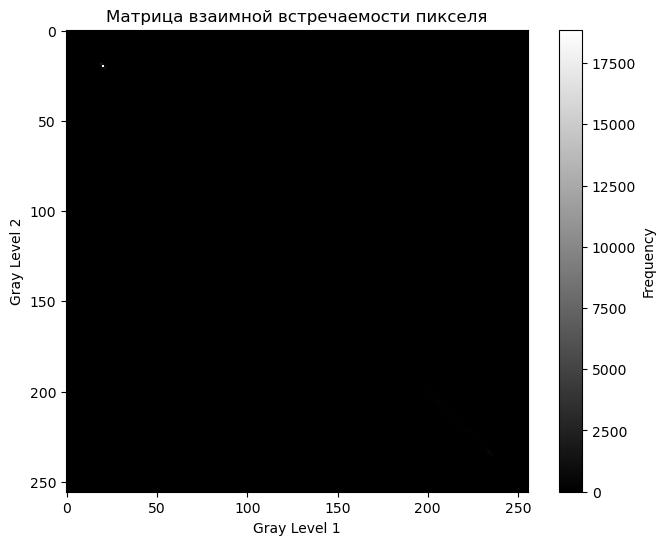

Textural Characteristics - Mean: 134.4163179174351, Variance: 6604.866560935103, Std Dev: 81.27033013920334
Lavs Characteristics - Mean: 0.0011349127535820683, Variance: 65.96804382475499, Std Dev: 8.122071399880388


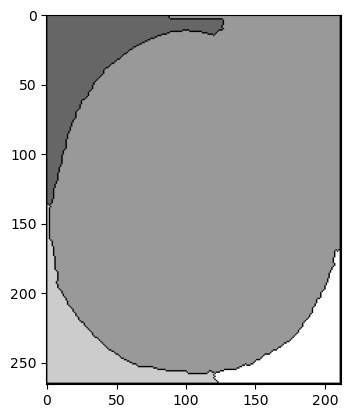

In [32]:
# Пример использования
image_path = "sick.jpg"
proc = Processing(image_path)

# Вызов методов
proc.histogramming()
glcm, features = proc.glcm_analysis()
print("Характеристи матрицы взаимной встречаемости пикселя")
print(features)
print("\nМатрица взаимной встречаемости пикселя")
print(glcm)
proc.visualize_glcm(glcm)
mean, variance, std_dev = proc.textural()
print(f"Textural Characteristics - Mean: {mean}, Variance: {variance}, Std Dev: {std_dev}") 
lap_mean, lap_variance, lap_std_dev = proc.lavs_characteristics()
print(f"Lavs Characteristics - Mean: {lap_mean}, Variance: {lap_variance}, Std Dev: {lap_std_dev}")
proc.watershed_segmentation()